# Satellite Imagery Classification


![image.png](https://images.theconversation.com/files/383032/original/file-20210208-21-1ucbyp7.jpg?ixlib=rb-4.1.0&rect=344%2C286%2C4363%2C2178&q=45&auto=format&w=1356&h=668&fit=crop)

#### Importing the required libraries and adjusting some settings

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

# Config, customize the bg color to white
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## 1. Loading the Dataset (from Huggin Face to PyTorch)

#### Formating, Visualising and narrowing the dataset
1. Utils
2. Dataset
3. EDA
4. Problem definition
5. Load dataset with PyTorch

#### 1. Utility methods
These are used for:
- A. Displaying images in a grid
- B. Displaying a pie

In [ ]:
import matplotlib.pyplot as plt
import math

def get_image(label, position=0):
    """
    Fetches an image from the dataframe based on label and position.
    """
    return df[df['label_2'] == label].iloc[position]['image']

def create_subplot_grid(num_images, images_per_row=4, figsize=(15, 15)):
    """
    Creates a grid of subplots to hold the images, ensuring 4 images per row.
    """
    # Calculate the number of rows required
    num_rows = math.ceil(num_images / images_per_row)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=figsize)

    # Flatten axes for easy iteration if there's more than 1 row
    axes = axes.flatten() if num_images > 1 else [axes]

    # Remove spacing between subplots
    plt.subplots_adjust(wspace=0)

    return fig, axes

def display_image_on_axis(image, axis, title=None):
    """
    Displays an image on a specific axis, optionally with a title.
    """
    axis.imshow(image)
    axis.axis('off')
    if title:
        axis.set_title(title)

def show_sample_images(labels, positions=None, images_per_row=4):
    """
    Displays multiple images in a grid, with 4 images per row.
    """
    if positions is None:
        positions = [0] * len(labels)

    # Create subplots grid with 4 images per row
    fig, axes = create_subplot_grid(len(labels), images_per_row)

    # Loop through each label and position to display the images
    for i, (label, position) in enumerate(zip(labels, positions)):
        image = get_image(label, position)
        display_image_on_axis(image, axes[i], title=f'Class {label}')

    # Hide any remaining unused axes (in case number of images < grid size)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()


In [ ]:
import plotly.express as px

def filter_data_by_threshold(df, threshold):
    above_threshold_df = df[df['Count'] >= threshold].copy()
    below_threshold_df = df[df['Count'] < threshold].copy()
    return above_threshold_df, below_threshold_df

def create_other_category_df(below_threshold_df):
    if below_threshold_df.empty:
        return None
    other_count = below_threshold_df['Count'].sum()
    other_percentage = below_threshold_df['Percentage'].sum()
    return pd.DataFrame([{'Label': 'Other', 'Count': other_count, 'Percentage': other_percentage}])

def prepare_label_distribution(df, threshold):
    above_threshold_df, below_threshold_df = filter_data_by_threshold(df, threshold if threshold is not None else 0)
    other_category_df = create_other_category_df(below_threshold_df)
    if other_category_df is not None:
        return pd.concat([above_threshold_df, other_category_df], ignore_index=True)
    return above_threshold_df

def plot_label_distribution(df, threshold):
    fig = px.pie(df, values='Count', names='Label',
                 title=f'Label Distribution with threshold={threshold}',
                 hover_data={'Percentage': ':.2f%', 'Count': True},
                 labels={'Percentage': '%', 'Count': 'Quantity', 'Label': 'Class'})

    fig.update_traces(
        textposition='inside',
        textinfo='percent+label',
        customdata=df[['Class']],  # Pass the "Class" column as customdata
        hovertemplate='%{label}<br>Quantity: %{value}<br>Percentage: %{percent:.2%}<br>Class: %{customdata[0]}'
    )
    fig.show()

#### 2. Dataset
1. Download parquet files
2. Download the datasets classes (e.g. 0 -> 'parking lot')
3. Format the dataset into a pandas Dataframe
4. Inspect a few row


1. Download 4.2 GB of labeled satellites imagery from Hugging Face

In [ ]:
!pip install datasets --upgrade --quiet
from datasets import load_dataset
# [Hugging Face - Dataset Card]  https://huggingface.co/datasets/jonathan-roberts1/RSI-CB256/viewer/default/train?f[label_2][value]=28
# Download 24 747 satellite images of 35 different classes (e.g. storage room, road, forest)
# (4.2 GB of data)
ds = load_dataset("jonathan-roberts1/RSI-CB256")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

(…)-00000-of-00010-e16600932e9bcbd0.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

(…)-00001-of-00010-bfd9182464eb6fab.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

(…)-00002-of-00010-dad01e4b0c906530.parquet:   0%|          | 0.00/439M [00:00<?, ?B/s]

(…)-00003-of-00010-8337a707f65a065b.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

(…)-00004-of-00010-023983ff36c6a800.parquet:   0%|          | 0.00/445M [00:00<?, ?B/s]

(…)-00005-of-00010-001293a153528593.parquet:   0%|          | 0.00/346M [00:00<?, ?B/s]

(…)-00006-of-00010-b794bcbcdbc17b70.parquet:   0%|          | 0.00/379M [00:00<?, ?B/s]

(…)-00007-of-00010-fba242e7ea5d6342.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

(…)-00008-of-00010-fff97d3ecdeedf48.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

(…)-00009-of-00010-f37d10205ca4f5d3.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24747 [00:00<?, ? examples/s]

2. Download and parse the Readme.md

In [ ]:
import requests
import yaml

# We fetch the Dataset's readme which contains each feature's label
readme_url = "https://huggingface.co/datasets/jonathan-roberts1/RSI-CB256/resolve/main/README.md"
response = requests.get(readme_url)

if response.status_code == 200:
    readme_content = response.text
    # We strip the rest of the Readme.md to only preserve the YAML
    # formatted data, nested between two '---'
    yaml_content = readme_content.split("---")[1].strip()
    # We parse the YAML
    readme_yaml = yaml.safe_load(yaml_content)
    label_2_mapping = readme_yaml['dataset_info']['features'][1]['dtype']['class_label']['names']
    # We store the mappings for later use
    label_2_map = {int(k): v for k, v in label_2_mapping.items()}
    print("Label 2 Mapping:", label_2_map)
else:
    print(f"Failed to download README. Status code: {response.status_code}")

Label 2 Mapping: {0: 'parking lot', 1: 'avenue', 2: 'highway', 3: 'bridge', 4: 'marina', 5: 'crossroads', 6: 'airport runway', 7: 'pipeline', 8: 'town', 9: 'airplane', 10: 'forest', 11: 'mangrove', 12: 'artificial grassland', 13: 'river protection forest', 14: 'shrubwood', 15: 'sapling', 16: 'sparse forest', 17: 'lakeshore', 18: 'river', 19: 'stream', 20: 'coastline', 21: 'hirst', 22: 'dam', 23: 'sea', 24: 'snow mountain', 25: 'sandbeach', 26: 'mountain', 27: 'desert', 28: 'dry farm', 29: 'green farmland', 30: 'bare land', 31: 'city building', 32: 'residents', 33: 'container', 34: 'storage room'}


In [ ]:
import pandas as pd
# 1. We convert the parquet files to a pandas Dataframe
df = pd.DataFrame(ds['train'])

In [ ]:
# Each row contains:
# - a broad class, which we will ignore (label_1), e.g. 0 for 'transportation'
# - a more specific class (label_2), e.g. 0 for 'parking lot'
# - the RGB image as Python PIL class of size 256X256
df.head(2)

label_1  label_2                                              image
0        0        0  <PIL.Image.Image image mode=RGB size=256x256 a...
1        0        0  <PIL.Image.Image image mode=RGB size=256x256 a...

#### 3. EDA: Exploration Data Analysis


Calculate Data Distribution

In [ ]:
# Calculate the distribution of each class
label_counts = df['label_2'].value_counts()
label_percentages = df['label_2'].value_counts(normalize=True) * 100

# Create a DataFrame with counts and percentages for each class
label_distribution_df = pd.DataFrame({
    'Class': label_counts.index,
    'Label': label_counts.index.map(label_2_map),
    'Count': label_counts.values,
    'Percentage': label_percentages.values
})

Visualise Data Distribution with a Pie

In [ ]:
SAMPLE_THRESHOLD = 1000 # -> We want enought data to train an accurate model
# So we only display classes with enought samples
pie_df = prepare_label_distribution(label_distribution_df.copy(), SAMPLE_THRESHOLD)
plot_label_distribution(pie_df, SAMPLE_THRESHOLD)

#### 4. Problem definition

1. Original space
2. Narrowed problem space



In [ ]:
# Print all the classes
label_2_mapping

{'0': 'parking lot',
 '1': 'avenue',
 '2': 'highway',
 '3': 'bridge',
 '4': 'marina',
 '5': 'crossroads',
 '6': 'airport runway',
 '7': 'pipeline',
 '8': 'town',
 '9': 'airplane',
 '10': 'forest',
 '11': 'mangrove',
 '12': 'artificial grassland',
 '13': 'river protection forest',
 '14': 'shrubwood',
 '15': 'sapling',
 '16': 'sparse forest',
 '17': 'lakeshore',
 '18': 'river',
 '19': 'stream',
 '20': 'coastline',
 '21': 'hirst',
 '22': 'dam',
 '23': 'sea',
 '24': 'snow mountain',
 '25': 'sandbeach',
 '26': 'mountain',
 '27': 'desert',
 '28': 'dry farm',
 '29': 'green farmland',
 '30': 'bare land',
 '31': 'city building',
 '32': 'residents',
 '33': 'container',
 '34': 'storage room'}

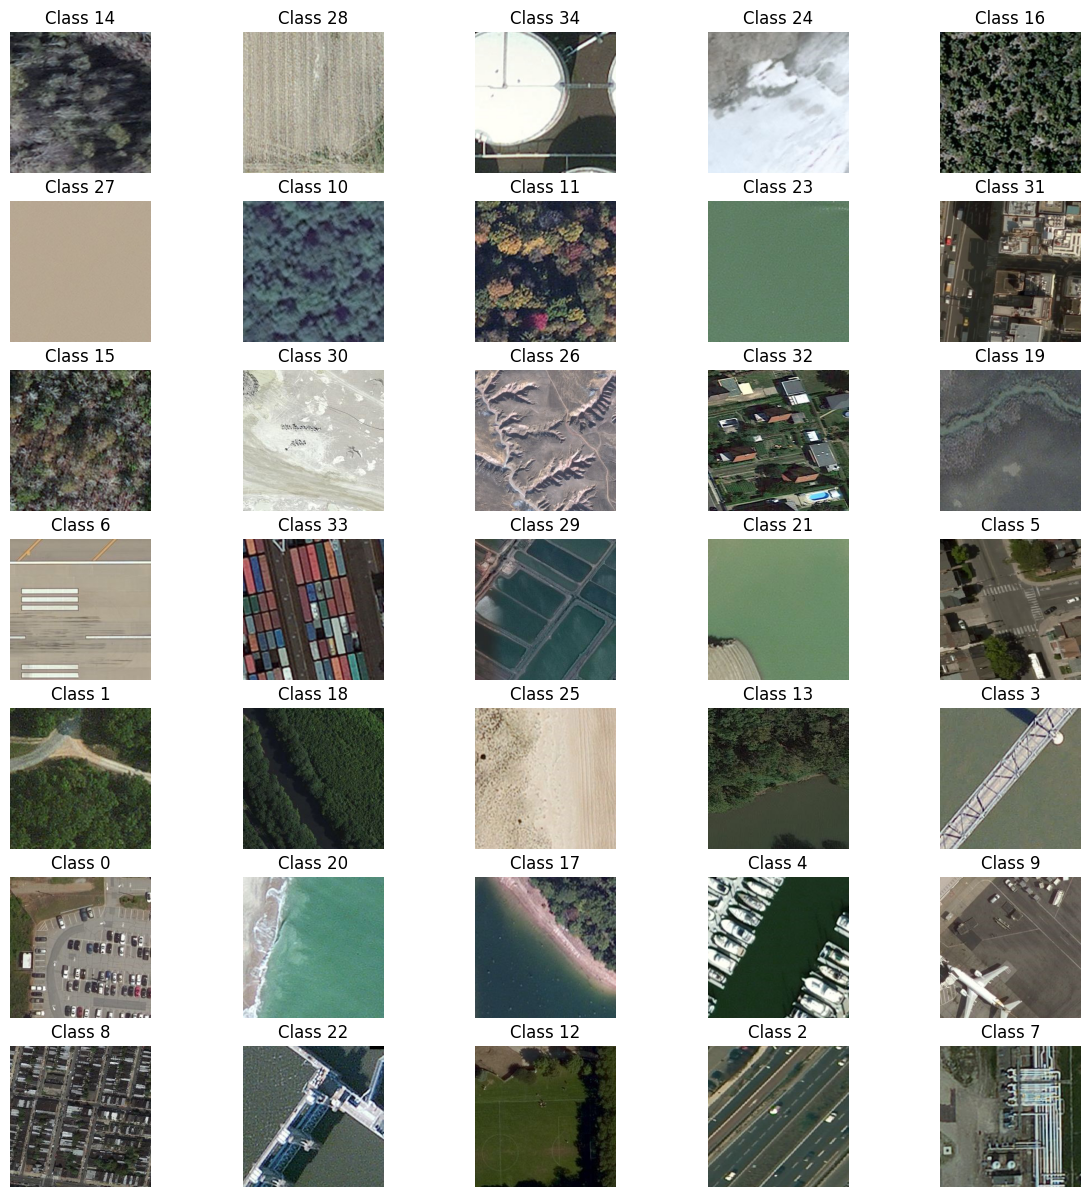

In [ ]:
# We visualize all the original classes
all_classes = label_distribution_df['Class'].unique()
show_sample_images(all_classes, None, 5)

We define a **realistic and more challenging** classification problem by selecting classes that share similarities in both color and shape, requiring the model to make subtle distinctions between them.

The overlap in visual features is as follow:
- **Dry farm**: predominantly yellow.
- **Sparse forest**: a mix of yellow and green.
- **Forest**: mainly green.
- **Sea**: shades of green.

Furthermore, the **shapes of trees**, **forest shadows**, and **sea waves** exhibit visual similarities, further complicating the classification process.

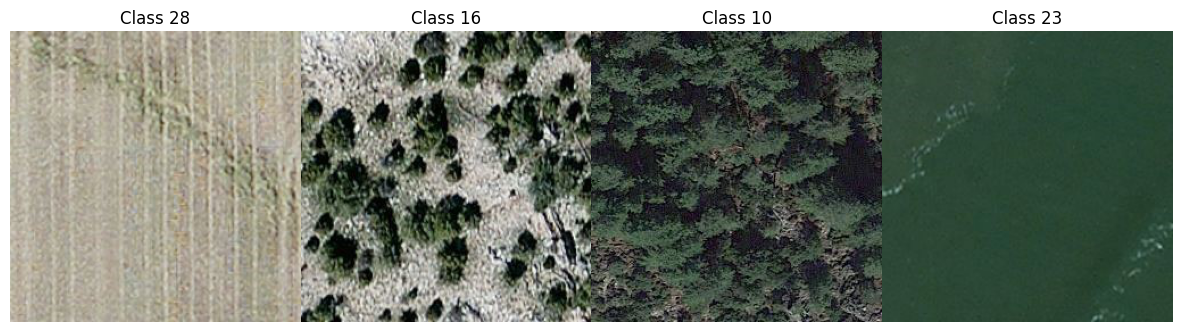

In [ ]:
# We manually select the target classes for classification:
classes = [
    28,             # dry farm
    16,             # sparse forest
    10,             # forest
    23              # sea
]

# We visualize one example from each target class to preview the dataset.
show_sample_images(classes, positions=[1, 2, 2, 6])

In [ ]:
# We create a Pandas Dataframe with the selected clases
target_df = df[df['label_2'].isin(classes)]
# we rename label_2 to class
target_df = target_df.rename(columns={'label_2': 'label'})
target_df.drop(columns=['label_1'], inplace=True)

# We print two sample rows
print(target_df.head(2))
# We print the quantity of samples for each class
target_df.label.value_counts()

      label                                              image
4184     10  <PIL.Image.Image image mode=RGB size=256x256 a...
4185     10  <PIL.Image.Image image mode=RGB size=256x256 a...


label
28    1309
16    1110
10    1082
23    1028
Name: count, dtype: int64

Adjust the labels to start from 0

In [ ]:
# Generate integers starting from 0
target_df['label'], unique_labels = pd.factorize(target_df['label'])

# Fix label mapping: integers 0, 1, 2, etc., mapped to their corresponding class names
label_mapping = {new_label: label_2_mapping[str(original_label)] \
                 for new_label, original_label in enumerate(unique_labels)}

label_mapping


{0: 'forest', 1: 'sparse forest', 2: 'sea', 3: 'dry farm'}

#### 5. Load dataset with PyTorch

Custom Pytorch Dataset utility class

In [ ]:
import torch
from torch.utils.data import Dataset

# We setup a custom dataset loader to read the
# dataset from the dataframe in the format label, image
# e.g. 10, <PIL.Image.Image image mode=RGB size=256x256 a...
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
class SatelliteDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.classes = sorted(df['label'].unique())
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

Applying transformations to images

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    # Changing the image size from 256 to 64x64 pixels
    transforms.Resize((64, 64)),
    # Add randomness for more realistic data
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    # Converting PIL images to tensors
    transforms.ToTensor()
])

In [ ]:
# We load the dataset and apply transformations to images
dataset = SatelliteDataset(target_df, transform=transform)
print(dataset.classes)

[0, 1, 2, 3]


The data consists of 64x64 px color images with 3 channels (RGB), each image tensor has the shape (3, 64, 64).

In [ ]:
# Print the first image's tensor and class
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 64, 64]) 0


tensor([[[0.2824, 0.2784, 0.3216,  ..., 0.2431, 0.2784, 0.2824],
         [0.3176, 0.3176, 0.2941,  ..., 0.2275, 0.2392, 0.2196],
         [0.2941, 0.2941, 0.2745,  ..., 0.2667, 0.2824, 0.2588],
         ...,
         [0.3098, 0.2431, 0.2314,  ..., 0.2824, 0.3333, 0.3294],
         [0.2392, 0.2667, 0.3294,  ..., 0.3255, 0.3020, 0.3216],
         [0.3098, 0.3686, 0.4039,  ..., 0.3098, 0.2667, 0.2980]],

        [[0.3373, 0.3294, 0.3647,  ..., 0.3137, 0.3490, 0.3569],
         [0.3843, 0.3765, 0.3490,  ..., 0.2863, 0.3020, 0.2824],
         [0.3647, 0.3608, 0.3373,  ..., 0.3216, 0.3373, 0.3137],
         ...,
         [0.3804, 0.3098, 0.2902,  ..., 0.3569, 0.4078, 0.4078],
         [0.3255, 0.3451, 0.4039,  ..., 0.4039, 0.3804, 0.4078],
         [0.4157, 0.4667, 0.4941,  ..., 0.3804, 0.3373, 0.3804]],

        [[0.3843, 0.3882, 0.4275,  ..., 0.3451, 0.3882, 0.4000],
         [0.4392, 0.4392, 0.4078,  ..., 0.3216, 0.3451, 0.3373],
         [0.4078, 0.4039, 0.3882,  ..., 0.3647, 0.3882, 0.

## 2. Training and Validation Datasets

Splitting the dataset into training, validation and test sets

In [ ]:
random_seed = 30
torch.manual_seed(random_seed);

In [ ]:
dataset_size = len(dataset)
val_size = int(dataset_size * 0.12)              # 12%
test_size = int(dataset_size * 0.15)             # 15%
train_size = len(dataset) - val_size - test_size # 73%

# Randomly split the images with PyTorch's built-in method random_split
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(3307, 543, 679)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size=128

Creating data loaders to load the data in batches

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [ ]:
def show_example(img, label):
    print('Label: ', label_2_mapping[str(label)], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Change the tensor dimensions to (64, 64, 3) for viewing it in Matplotlib

Label:  avenue (1)


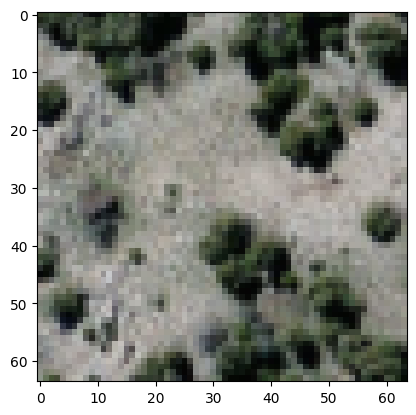

In [ ]:
show_example(*dataset[1500])

Label:  highway (2)


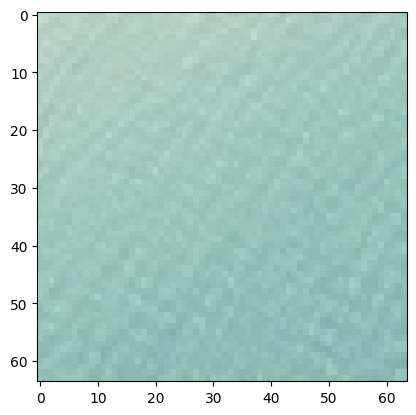

In [ ]:
show_example(*dataset[2845])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

Using the make_grid method from torchvision to look at batches of images from the dataset. Each time the following code is run, we get a different batch, since the sampler shuffles the indices before creating batches.

images.shape: torch.Size([128, 3, 64, 64])


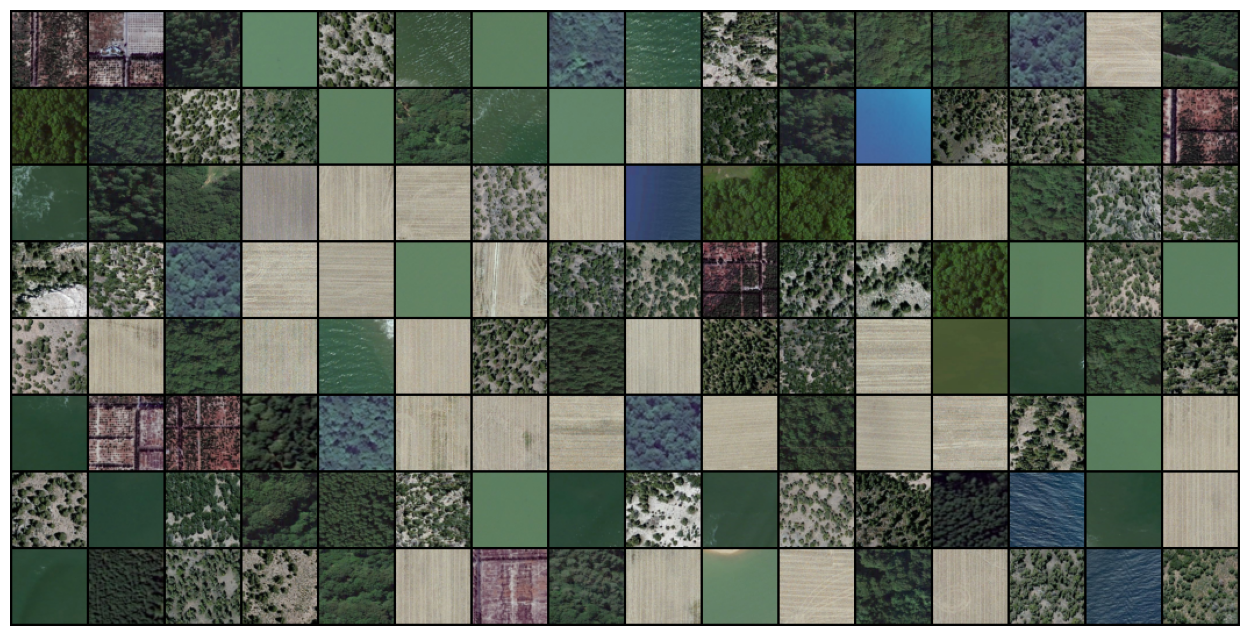

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## 3. Using GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## 4. Training loop implemantation

Define two functions: fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() # prevent accumulating gradients
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        # Check for val_acc = 1 (100%)
        if result.get('val_acc', 0) == 1.0:  # Assuming 'val_acc' is part of the result dictionary
            print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
            history.append(result)
            break
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## 5. Defining the Models
1. Custom Convolutional Neural Network
2. Pretrained model

### 1. Custom CNN

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class SatelliteClassificationModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # Initial feature extraction
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Detects low-level features (e.g., edges)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Deepens feature extraction
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Halves spatial dimensions (downsampling)

            # More complex feature extraction
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Captures more detailed patterns
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Deepest feature extraction layer
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Focuses on even more complex features
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Classification head
            nn.Flatten(),  # Prepares data for fully connected layers
            nn.Linear(256*8*8, 1024),  # Dense layer with 1024 neurons
            nn.ReLU(),
            nn.Linear(1024, 512),  # Further compression of features
            nn.ReLU(),
            nn.Linear(512, 4)  # Final output layer for 4 classes
        )

    def forward(self, xb):
        return self.network(xb)

Initializing the custom CNN model

In [ ]:
model = SatelliteClassificationModel()
model

SatelliteClassificationModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=1024, bias=True)
    (17): ReLU()
    (18): 

### 2. Resnet50

In [ ]:
class PretrainedModel(ImageClassificationBase):
    def __init__(self, model, num_classes, intermediate_dim=512):
        super().__init__()
        self.network = model
        # Replace the final fully connected layer with a new one
        in_features = self.network.fc.in_features  # 2048 for ResNet50
        self.network.fc = nn.Sequential(
            nn.Linear(in_features, intermediate_dim),  # Convert from 2048 -> 512
            nn.ReLU(),
            nn.Linear(intermediate_dim, num_classes)   # Final layer: 512 -> num_classes
        )

    def forward(self, xb):
        return self.network(xb)

Loading the pretrained model


In [ ]:
# https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights
pretrained_resnet = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


In [ ]:
# Set the number of output classes and intermediate dimension (512 to match your CNN)
num_classes = len(dataset.classes)

# Initialize the model
pretrained_model = PretrainedModel(pretrained_resnet, num_classes)
pretrained_model

PretrainedModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

## 6. Training the Model


Before training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [ ]:
transfer_learning = False
if transfer_learning:
  import copy
  model = to_device(copy.deepcopy(pretrained_model), device)
else:
  model = to_device(SatelliteClassificationModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 1.3884938955307007, 'val_acc': 0.2090473771095276}

We'll use the following hyperparmeters (learning rate, no. of epochs, batch_size etc.) to train our model.



In [ ]:
max_num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(max_num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.2925, val_loss: 0.8913, val_acc: 0.5953
Epoch [1], train_loss: 0.8800, val_loss: 0.7813, val_acc: 0.4543
Epoch [2], train_loss: 0.5022, val_loss: 0.3546, val_acc: 0.8001
Epoch [3], train_loss: 0.3332, val_loss: 0.4271, val_acc: 0.8880
Epoch [4], train_loss: 0.2157, val_loss: 0.1852, val_acc: 0.9209
Epoch [5], train_loss: 0.0945, val_loss: 0.1711, val_acc: 0.9313
Epoch [6], train_loss: 0.0639, val_loss: 0.0780, val_acc: 0.9853
Epoch [7], train_loss: 0.0476, val_loss: 0.0669, val_acc: 0.9866
Epoch [8], train_loss: 0.0313, val_loss: 0.0664, val_acc: 0.9892
Epoch [9], train_loss: 0.0167, val_loss: 0.0934, val_acc: 0.9853


Plotting the valdation set accuracies to study how the model improves over time.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

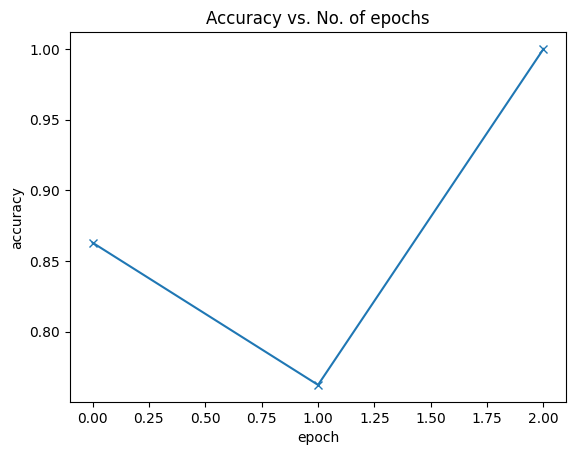

In [ ]:
plot_accuracies(history)


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

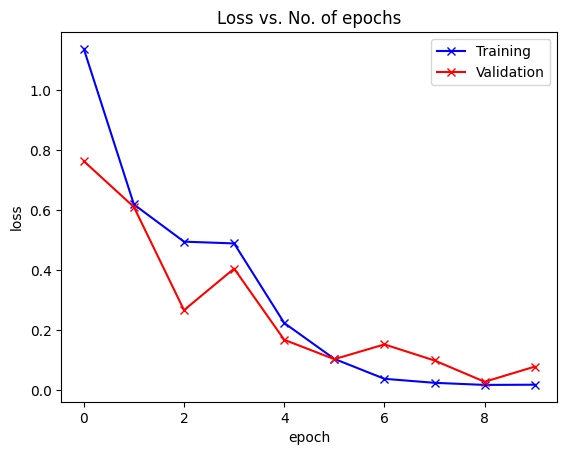

In [ ]:
plot_losses(history)

## 7. Inference: test with individual images

In [ ]:
test_dataset = test_ds

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: 0 , Predicted: 0


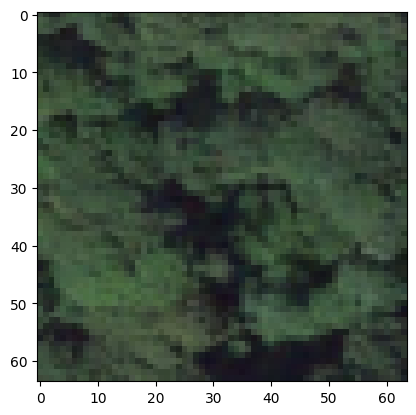

In [ ]:
img, label = test_dataset[200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: 3 , Predicted: 3


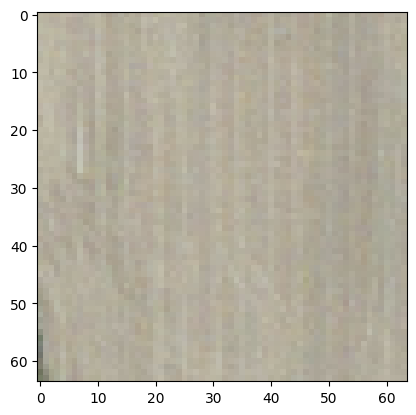

In [ ]:
img, label = test_dataset[300]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


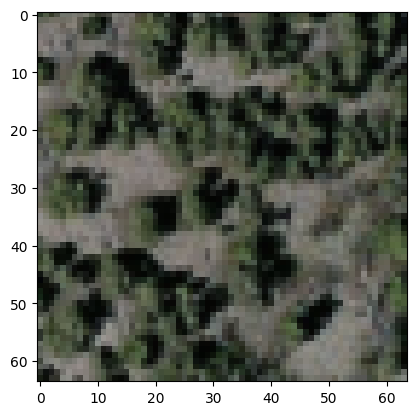

In [ ]:
img, label = test_dataset[274]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.01989390328526497, 'val_acc': 0.9921017289161682}

## 8. Saving and loading the model

In [ ]:
torch.save(model.state_dict(), 'satellite-classification-model.pth')